**Image Classifier Using CNN**

1. Importing Libraries

In [14]:
#Libraries 

import cv2
import imghdr
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

2. Available Computing Devices

In [15]:
gpus1=tf.config.experimental.list_physical_devices('CPU')
gpus2=tf.config.experimental.list_physical_devices('GPU')
gpus1
#gpus2


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

3. Cleaning and Loading Data

In [16]:
#Cleaning Data

data_dir='Data_set'
image_ext=['jpeg','jpg','bmp','png']

for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir,image_class)):
        image_path = os.path.join(data_dir,image_class,image)
        try:
            img=cv2.imread(image_path)
            tip=imghdr.what(image_path)
            if tip not in image_ext:
                print( ' image not in ext {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            #os.remove(image_path)

Found 955 files belonging to 5 classes.


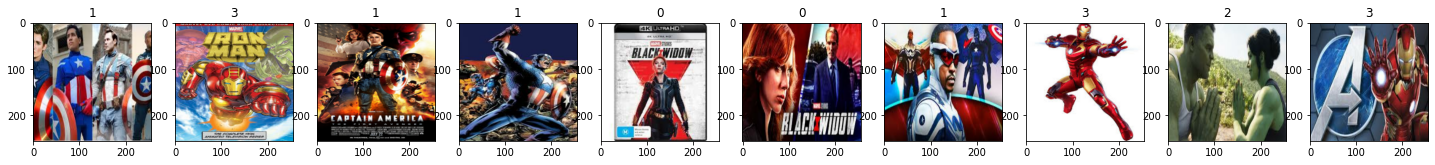

In [39]:
#Load data

data=tf.keras.utils.image_dataset_from_directory(data_dir)
data_iterator=data.as_numpy_iterator()
batch=data_iterator.next()


fig,ax=plt.subplots(ncols=10,figsize=(25,25))
for idx,img in enumerate(batch[0][:10]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])


# class 0-Blackwidow 
# class 1- Captain america 
# class 2- Hulk
# class 3-Ironman 
# class 4- Thor


4. Data preprocessing

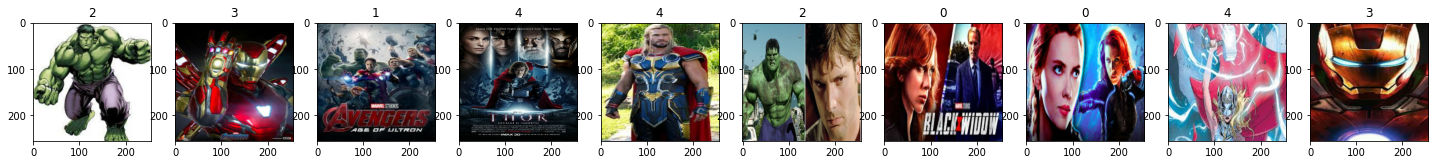

In [40]:
#scale data

data=data.map(lambda x,y :(x/255,y))
batch=data.as_numpy_iterator().next()

fig,ax=plt.subplots(ncols=10,figsize=(25,25))
for idx,img in enumerate(batch[0][:10]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

#Split data
train_s=int(len(data)*.7)
val_s=int(len(data)*.2)+1
test_s=int(len(data)*.1)+1

len(data)==(train_s+test_s+val_s)

train=data.take(train_s)
val=data.skip(train_s).take(val_s)
test=data.skip(train_s+val_s).take(test_s)

5. Model

In [19]:
#model

from  tensorflow.keras.models  import Sequential
from  tensorflow.keras.layers  import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
 
model=Sequential()

model.add(Conv2D(16,(3,3),1,activation='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32,(3,3),1,activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64 ,(3,3),1,activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dropout(0.2))

model.add(Dense(512,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(5,activation='softmax'))

model.compile('adam',loss=tf.losses.sparse_categorical_crossentropy,metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 64)      

6. Training

In [27]:
#Train

logdir='logs' 

tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logdir)  
history=model.fit( train,epochs=20,validation_data=val,callbacks=[tensorboard_callback])

Epoch 1/20
21/21 [==============================] - 18s 808ms/step - loss: 0.0395 - accuracy: 0.9940 - val_loss: 0.3469 - val_accuracy: 0.9330
Epoch 2/20
21/21 [==============================] - 21s 973ms/step - loss: 0.0117 - accuracy: 0.9970 - val_loss: 0.4588 - val_accuracy: 0.9107
Epoch 3/20
21/21 [==============================] - 23s 1s/step - loss: 0.0075 - accuracy: 0.9985 - val_loss: 0.4958 - val_accuracy: 0.8929
Epoch 4/20
21/21 [==============================] - 24s 1s/step - loss: 0.0183 - accuracy: 0.9970 - val_loss: 0.4219 - val_accuracy: 0.9196
Epoch 5/20
21/21 [==============================] - 23s 1s/step - loss: 0.0116 - accuracy: 0.9985 - val_loss: 0.3583 - val_accuracy: 0.9241
Epoch 6/20
21/21 [==============================] - 24s 1s/step - loss: 0.0227 - accuracy: 0.9911 - val_loss: 0.4960 - val_accuracy: 0.8973
Epoch 7/20
21/21 [==============================] - 28s 1s/step - loss: 0.0202 - accuracy: 0.9955 - val_loss: 0.3457 - val_accuracy: 0.9241
Epoch 8/20
21/

7. Performance of Model on Training and Validation data

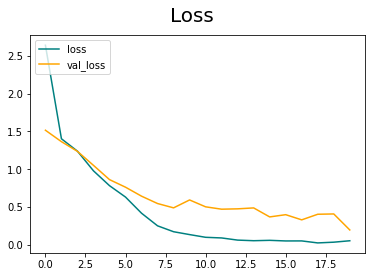

In [21]:
#plot performance

#history
#history.history
fig=plt.figure()
plt.plot(history.history['loss'],color='teal',label='loss')
plt.plot(history.history['val_loss'],color='orange',label='val_loss')
fig.suptitle('Loss',fontsize=20)
plt.legend(loc="upper left")
plt.show()

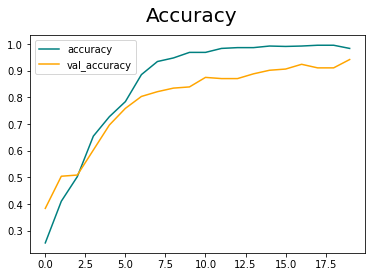

In [22]:
fig=plt.figure()
plt.plot(history.history['accuracy'],color='teal',label='accuracy')
plt.plot(history.history['val_accuracy'],color='orange',label='val_accuracy')
fig.suptitle('Accuracy',fontsize=20)
plt.legend(loc="upper left")
plt.show()

8. Performance of model on Test data

In [23]:
# Evaluate Performance

#Evaluate
from tensorflow.keras.metrics import Precision,Recall,SparseCategoricalAccuracy


p=Precision()
r=Recall()
acc=SparseCategoricalAccuracy()

for batch in test.as_numpy_iterator():
    X,y =batch
    yhat=model.predict(X)
    ans=np.argmax(yhat,axis=1)
    print(ans)
    print(y)
    p.update_state(y,ans)
    r.update_state(y,ans)
    #acc.update_state(y,ans)


pre=p.result().numpy()
rec=r.result().numpy()
f1=2*pre*rec/(pre+rec)
print('\n\n')
print('F1 Score : ',f1,sep='')

1/1 [==============================] - 0s 183ms/step
[0 2 3 1 4 0 1 2 2 4 2 0 3 3 4 4 2 1 3 2 3 0 3 3 2 3 1 2 2 0 3 3]
[0 1 3 1 4 0 1 2 2 4 2 0 3 3 4 4 2 1 3 2 3 0 3 0 2 3 1 2 2 0 4 3]
1/1 [==============================] - 0s 194ms/step
[2 1 2 3 2 0 2 4 1 0 4 3 0 4 1 0 2 4 2 1 1 0 1 2 3 3 0]
[2 1 2 3 4 0 2 4 1 0 4 3 0 4 1 0 2 4 2 1 1 0 1 3 3 3 0]



F1 Score : 0.9894736645558542


9. Performance of Model on Unknown Test cases

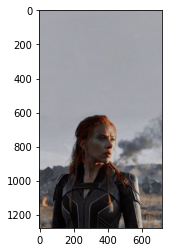

1/1 [==============================] - 0s 56ms/step
Black widow


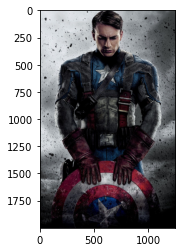

1/1 [==============================] - 0s 40ms/step
Captain America


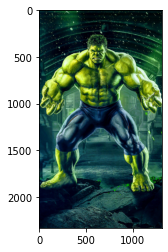

1/1 [==============================] - 0s 64ms/step
Hulk


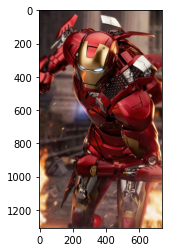

1/1 [==============================] - 0s 48ms/step
Iron man


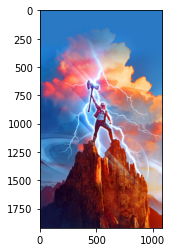

1/1 [==============================] - 0s 72ms/step
Thor


In [58]:
# Test 

Test_case='Test_cases'
for im in os.listdir(Test_case):
    im_path = os.path.join(Test_case,im)
    img = cv2.imread(im_path)
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.show()

    resize=tf.image.resize(img,(256,256))
    #plt.imshow(resize.numpy().astype(int))
    #plt.show()

    np.expand_dims(resize,0)
    yhat=model.predict(np.expand_dims(resize/255,0))

    c=np.argmax(yhat,axis=1)
    output={0:'Black widow',1:'Captain America',2:'Hulk',3:'Iron man',4:'Thor'}
    print(output.get(c[0]))

10. Save the Model

In [25]:
#Save the model

from  tensorflow.keras.models import load_model
model.save(os.path.join('models','Avengers_Image_classifier.h5'))

11. Bonus Task

In [26]:
# Bonus Task - Transfer learning 

Bonus_set='Bonus_Data_set' 
